In [47]:
import numpy as np
from icecream import ic
from tqdm import tqdm


### Loading a problem given from prof

In [48]:
TRAIN_TEST_RATIO=1

problem = np.load('problem_0.npz')
x_1 = problem['x']
y_1 = problem['y']

problem_len=len(y_1)

test_size=int(TRAIN_TEST_RATIO*problem_len)

x_train=x_1[:,0:test_size]
y_train=y_1[0:test_size]


# x_test=x_1[:,test_size:]
# y_test=y_1[test_size:]


### Getting numpy functions

In [49]:
unary_ops = [
    np.negative,
    np.abs,
    # np.sqrt,
    # np.exp,
    # np.log,
    np.sin,
    np.cos,
    np.tan,
#     np.arcsin,
#     np.arccos,
#     np.arctan,
#     np.ceil,
#     np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    # np.maximum,
    # np.minimum,
    # np.mod
]


### Symbolic regression

 31%|███       | 31/100 [00:12<00:23,  2.95it/s]

Start takeover after 30 gen


 42%|████▏     | 42/100 [00:16<00:20,  2.87it/s]

Start takeover after 41 gen


 56%|█████▌    | 56/100 [00:21<00:14,  2.96it/s]

Start takeover after 55 gen


 76%|███████▌  | 76/100 [00:29<00:07,  3.03it/s]

Start takeover after 75 gen


 89%|████████▉ | 89/100 [00:34<00:03,  2.89it/s]

Start takeover after 88 gen


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]

np.multiply(np.subtract(x2, np.multiply(np.multiply(70.70385544826502, 52.73244310952998), np.multiply(x0, -38.489887618995326))), np.subtract(np.negative(x1), -6.005207908690096))
Best Fitness: 15851226531979.9
Best Fitness History: [24261795630454.21, 24261789685647.41, 23759885434309.066, 23475664573298.773, 21153230359687.24, 21053976858809.86, 19934396396897.676, 19920265840736.688, 17820048691385.58, 17740615238544.953, 17652133621519.293, 17651872780823.914, 17622007487563.395, 15851226531979.9], changed 14 times
Best Tree:


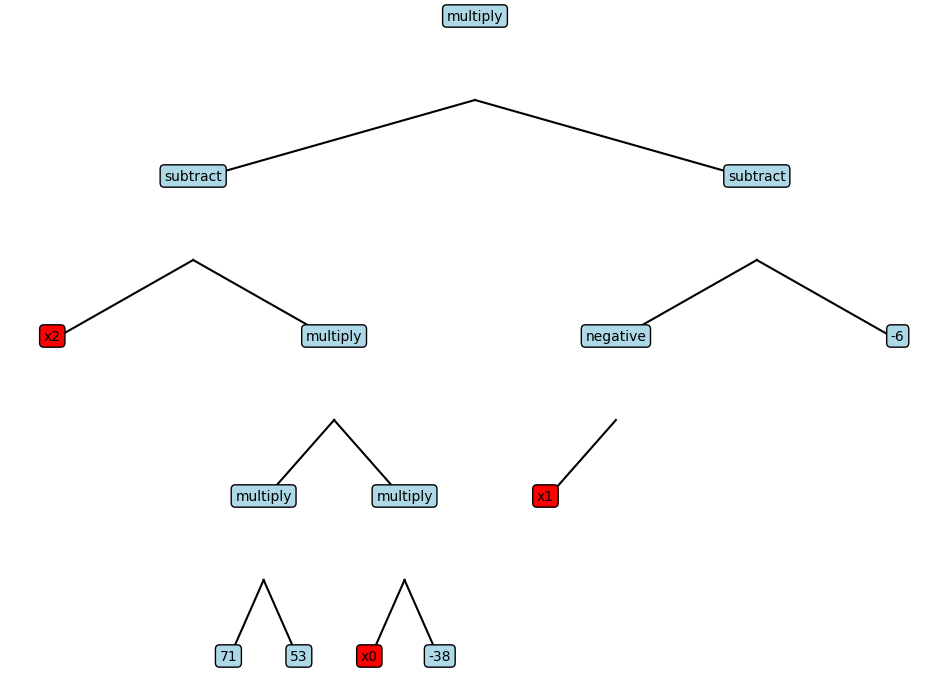

In [50]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_size, max_generations, mutation_rate, elitism_size, grow_full_ratio):
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.best_fitness_history = []
        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio
        

        self.population = [Tree("grow") for _ in range(int(population_size * self.grow_full_ratio))] + [Tree("full") for _ in range(int(population_size * (1 - self.grow_full_ratio)))]

    # Parents selection
    def select_parents(self):
        if np.random.rand() < 0:
            return self.select_parents_tournament()
        else:
            return self.rank_based_selection()

    def select_parents_tournament(self):
        tournament_size = 7
        tournament = list(np.random.choice(self.population, tournament_size))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]

    # def fitness_proportional_selection(self, n_elems=2): #TODO:   implement this
    def rank_based_selection(self, n_elems=2):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        """
        fitnesses = np.array([tree.fitness for tree in self.population])
        ranks = np.argsort(fitnesses)
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population, n_elems, p=probabilities)

    def select_parents_roulette(self):
        fitnesses = [tree.fitness for tree in self.population]
        total_fitness = sum(fitnesses)
        probabilities = [f / total_fitness for f in fitnesses]
        parent1, parent2 = np.random.choice(self.population, size=2, p=probabilities)
        return parent1, parent2

    def mutate(self, tree):
        if np.random.rand() < self.mutation_rate:
            if np.random.rand() < 0.5:
                tree.mutate_subtree()
            else:
                tree.mutate_single_node()

    def offspring_generation(self):
        new_population = []

        # Elitism   
        elite_individuals = self.population[:self.elitism_size]
        new_population.extend(elite_individuals)

        
        #Main loop
        while len(new_population) < self.population_size:
            parent1, parent2 = self.select_parents()
            offsprings=[]
            if(np.random.rand() < 0.05):
                parent_clone=parent1.copy_tree()
                self.mutate(parent_clone)
                Tree.collapse_branch(parent_clone.root)
                offsprings.append(parent_clone)

            else:    
                offspring1,offspring2=Tree.crossover(parent1, parent2)
                if(offspring1 is not None or offspring2 is not None):
                    Tree.collapse_branch(offspring1.root)
                    Tree.collapse_branch(offspring2.root)
                
                    # self.mutate(offspring1)
                    # self.mutate(offspring2)
        
                    offsprings.append(offspring1)
                    offsprings.append(offspring2)
            new_population.extend(offsprings)
                
        return new_population


    def evolve(self):
        best_tree = None
        best_fitness = np.inf
        take_over = False
        self.population.sort(key=lambda x: x.fitness) 
        for generation in tqdm(range(self.max_generations)):
            
            if take_over:
                #trasform the population in set and then back to list to remove duplicates
                self.population = list(set(self.population))
                #sort the population based on fitness
                self.population.sort(key=lambda x: x.fitness)
                self.population = self.population[:int(self.population_size*0.1)]
                new_trees = [Tree("full") for _ in range(int(self.population_size*0.3))]+[Tree("grow") for _ in range(int(self.population_size*0.3))]
                self.population.extend(new_trees)
            
            
            new_population=self.offspring_generation()
            

            self.population += new_population
            for tree in self.population:
                tree.compute_fitness()
            generation_fitnesses = [tree.fitness for tree in self.population]
            generation_best_fitness = min(generation_fitnesses)

            if generation_best_fitness < best_fitness:
                best_fitness = generation_best_fitness
                best_tree = self.population[np.argmin(generation_fitnesses)]
                self.best_fitness_history.append(best_fitness)
            #trim the population to the best population_size
            self.population.sort(key=lambda x: x.fitness)
            self.population = self.population[:self.population_size]
            # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
            

            n_best = [elem for elem in self.population if elem.fitness == self.population[0].fitness]
            take_over = False
            if len(n_best) > 0.9 * self.population_size:
                    take_over = True
                    print(f"Start takeover after {generation} gen")      
                
        return best_tree, best_fitness


TREE_DEPTH = 4
VAR_NUM = x_train.shape[0]

# Tree.set_params(unary_ops, binary_ops, VAR_NUM, 75,TREE_DEPTH, x_train, y_train, x_test, y_test)
Tree.set_params(unary_ops, binary_ops, VAR_NUM, 75,TREE_DEPTH,x_train,y_train)


regressor = SymbolicRegression(
    population_size=100,
    max_generations=100,
    mutation_rate=0.1,
    elitism_size=2,
    grow_full_ratio=0.7,
    # train_data=(x_train, y_train)   # per lexicase
)

#TODO: fare in modo che la stessa variabile possa comparire piu' volte
best_tree, best_fitness = regressor.evolve()
print(best_tree.to_np_formula())
print(f"Best Fitness: {best_fitness}")
print(f"Best Fitness History: {regressor.best_fitness_history}, changed {len(regressor.best_fitness_history)} times")
print("Best Tree:")
best_tree.add_drawing()



# print(x.shape)
# # print(x)
# # print([x[0][0]]+[x[1][0]]+[x[2][0]])
# print(regressor.population[0].fitness)
# regressor.population[0].print_tree()
# print(regressor.population[0].evaluate_tree([x[0][0]]+[x[1][0]]+[x[2][0]]))
# print(regressor.population[0].evaluate_tree(x[:,0]))
# print("Best Tree:")
# best_tree.print_tree()
# print(f"Best Fitness: {best_fitness}")



In [51]:
#test the tree on the test set



